In [1]:
!wget https://github.com/muhammadnajie/ronelo-homecare-apps/raw/main/datasets/trdg_dataset.zip

--2021-05-28 09:45:18--  https://github.com/muhammadnajie/ronelo-homecare-apps/raw/main/datasets/trdg_dataset.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/muhammadnajie/ronelo-homecare-apps/main/datasets/trdg_dataset.zip [following]
--2021-05-28 09:45:18--  https://raw.githubusercontent.com/muhammadnajie/ronelo-homecare-apps/main/datasets/trdg_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41819373 (40M) [application/zip]
Saving to: ‘trdg_dataset.zip’

trdg_dataset.zip    100%[===================>]  39.88M   101MB/s    in 0.4s    

2021-05-28 09:45:20 (101 MB/s) - ‘trdg_datas

In [2]:
!unzip -q trdg_dataset.zip -d .

In [3]:
!ls

sample_data  test  train  trdg_dataset.zip


In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import string
from PIL import Image
from sklearn.utils import shuffle
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, 
    BatchNormalization, Bidirectional, LSTM,
    Softmax
)
import csv
from PIL import Image
from time import process_time

In [5]:
filenames = []
contents   = []
with open("train/sentences.csv", "r") as f:
  reader = csv.DictReader(f, delimiter=',')
  for line in reader:
    filenames.append(line['name'])
    contents.append(line['content'])

In [6]:
X = []

start_time = process_time()

print("Process: loading images into memory ....")

for fn in filenames:
  with Image.open(f'train/{fn}', 'r') as img:
    img = img.resize((784, 32), Image.ANTIALIAS)
    img = np.asarray(img)
    img = img[:, :, :3]
    X.append(img)

X = np.asarray(X)
print(f"No of Images loaded :{X.shape[0]}")

finish_time = process_time()
print(f"Information: load images into memory took { round(finish_time-start_time, 2) } seconds")

Process: loading images into memory ....
No of Images loaded :3500
Information: load images into memory took 4.37 seconds


Text(0.5, 1.0, 'BASKET-HILTED FISHPOLES COLLUSIVE')

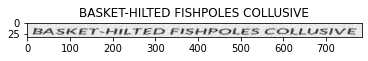

In [7]:
idx = 600
plt.imshow(X[idx])
plt.title(contents[idx])

In [25]:
symbols = f" {string.ascii_letters}{string.digits}.,*&!@~():`^]';|-"

MAX_CHAR = 49
SYMBOLS_COUNT = len(symbols)
IMG_COUNT = len(X)
CHANNELS = 3
 
print(f"Characters : {symbols}")
print(f"No of chars : {SYMBOLS_COUNT}")
print(f"No of chars : {IMG_COUNT}")

Characters :  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,*&!@~():`^]';|-
No of chars : 80
No of chars : 3500


In [9]:
y_shape = (IMG_COUNT, MAX_CHAR, SYMBOLS_COUNT) 
Y = np.zeros(shape=y_shape) 

for example_no, name in enumerate(contents): #index, sentence
    for letter_no, letter in enumerate(name): #iterate through sentence
        try:
            Y[example_no][letter_no][symbols.index(letter)]=1
        except:
            print(letter, end=" ")

In [10]:
X, Y, filenames, contents = shuffle(X, Y, filenames, contents, random_state=1)

In [12]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [258]:
# 
# X_train = np.reshape(X_train, (X.shape[0], X.shape[1], X.shape[2], CHANNELS))
# X_test = np.reshape(X_train, X_train.shape)
# print("Shape of X is :",X.shape)

Shape of X is : (3500, 32, 784, 3)


In [27]:
X.shape

(3500, 32, 784, 3)

In [22]:
idx = np.where(Y[0][0] == 1)[0][0]
print(idx)
print(contents[0])
print(symbols[idx])

29
Celtism monostely
C


In [23]:
def OCRModel():
    img   = Input((X.shape[1], X.shape[2], CHANNELS))
    conv1 = Conv2D(16,(3,3), activation='relu', padding='same')(img)
    mp1   = MaxPool2D((2,2), padding='same')(conv1)
    conv2 = Conv2D(32,(3,3), activation='relu', padding='same')(mp1)
    mp2   = MaxPool2D((2,2), padding='same')(conv2)
    conv3 = Conv2D(64,(3,3), activation='relu', padding='same')(mp2)
    mp3   = MaxPool2D((2,2), padding='same')(conv3)
    conv4 = Conv2D(128,(3,3), activation='relu', padding='same')(mp3)
    mp4   = MaxPool2D((2,2), padding='same')(conv4)
    conv5 = Conv2D(256,(3,3), activation='relu', padding='same')(mp4)
    mp5   = MaxPool2D((2,1), padding='same')(conv5)
    conv6 = Conv2D(256,(3,3), activation='relu', padding='same')(mp5)
    mp6 = MaxPool2D((1,3), padding='same')(conv6)
    bn1   = BatchNormalization()(conv6)
    sq    = tf.squeeze(bn1, axis=1)

    rn1   = Bidirectional(LSTM(256,return_sequences=True))(sq)
    rn2   = Bidirectional(LSTM(256,return_sequences=True))(rn1)

    exd     = tf.expand_dims(rn2,axis=2)
    mapping = Conv2D(len(symbols),(2,2), activation='relu',padding='same')(exd)
    mapping = tf.squeeze(mapping,axis=2)
    mapping = Softmax()(mapping)

    # bn = keras.layers.BatchNormalization()(conv3)
    model   = keras.Model(img,mapping)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [26]:
OCR = OCRModel()
OCR.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 784, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 784, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 392, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 392, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 196, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 196, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 98, 64)         0     

In [31]:
class AccCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.998):
      self.model.stop_training = True

    if(logs.get('val_accuracy') > 0.95):
      self.model.stop_training = True

callback = AccCallback()

In [32]:
OCR = OCRModel()
history = OCR.fit(X, Y, 
                  validation_split = 0.2,
                  epochs = 50,
                  callbacks=[callback])

Epoch 1/50
88/88 [==============================] - 18s 139ms/step - loss: 1.4554 - accuracy: 0.4545 - val_loss: 1.5299 - val_accuracy: 0.0257
Epoch 2/50
88/88 [==============================] - 10s 118ms/step - loss: 1.3453 - accuracy: 0.5205 - val_loss: 1.4869 - val_accuracy: 0.1954
Epoch 3/50
88/88 [==============================] - 10s 119ms/step - loss: 1.3085 - accuracy: 0.5372 - val_loss: 1.8306 - val_accuracy: 0.2430
Epoch 4/50
88/88 [==============================] - 10s 119ms/step - loss: 1.3035 - accuracy: 0.5445 - val_loss: 1.5195 - val_accuracy: 0.4026
Epoch 5/50
88/88 [==============================] - 10s 119ms/step - loss: 1.2859 - accuracy: 0.5581 - val_loss: 1.6448 - val_accuracy: 0.6238
Epoch 6/50
88/88 [==============================] - 10s 119ms/step - loss: 1.2700 - accuracy: 0.5503 - val_loss: 1.6438 - val_accuracy: 0.6150
Epoch 7/50
88/88 [==============================] - 10s 119ms/step - loss: 1.2613 - accuracy: 0.5560 - val_loss: 1.5405 - val_accuracy: 0.6280

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(OCR, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [42]:
pred = OCR.predict(X)

83
Correctly predicted: 2.0%
predicted: HYTEEHHVAALEEE  TTIIINSSSSSS

Original: HYPERVITALIZED HALTINGNESS


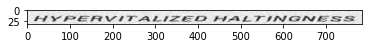

In [65]:
count = 0
index = 1
for idx in range(len(pred)):
  c = ""
  for i in range(MAX_CHAR):
      c += symbols[np.argmax(pred[idx][i])]
      # print(c)
  if c[:-1].strip() == contents[idx].strip():
    count += 1

print(count)
print(f"Correctly predicted: { round(count/len(pred), 2) * 100 }%" )

print("predicted:",c.strip())
print("\nOriginal:",contents[idx])
plt.imshow(X[idx][:,:,:3])


49
predicted: THELYBLAST NATIONALTYY

Orignal: THELYBLAST NATIONALTY


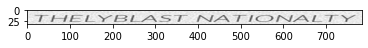

In [62]:
index = 15
c=""
print(len(pred[0]))
for i in range(len(pred[0])):
    c=c+(symbols[np.argmax(pred[index][i])])
    # print(c)
print("predicted:",c.strip())
print("\nOrignal:",contents[index])
plt.imshow(X[index][:,:,:3])

In [ ]:
count = 0
for i in range(len(contents)):
  if c.strip() == contents[index].strip():
    count += 1
count

0

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

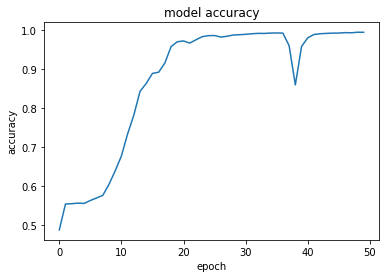

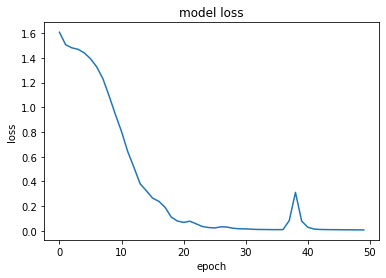

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()